## Tiny NeRF (A PyTorch implementation)

So, this weekend, I was catching up on this _cool paper_ titled [*NeRF: Representing scenes as neural radiance fields for view synthesis*](https://arxiv.org/abs/2003.08934)!

The authors released a TensorFlow implementation [here](https://github.com/bmild/nerf). Deciding to delve deeper, I ported their code to PyTorch, cause why not!

> *DISCLAIMER*: This notebook (and repository) is work-in-progress. Although I have rigorously tested most modules in here (to faithfully replicate the original implementation), my implementation at places deviates from the authors'. Comments/criticism welcome!

> All functions that have a `#TESTED` under the docstring imply that they have been tested against their corresponding tensorflow impls.

In [1]:
# Import all the good stuff
from typing import Optional

import numpy as np
import torch
import matplotlib.pyplot as plt

import astra
from skimage.transform import radon, rescale, rotate
from scipy.interpolate import RectBivariateSpline
from collections import namedtuple
from matplotlib.animation import FuncAnimation

astra.test()

ASTRA Toolbox v2.2.0
Getting GPU info... GPU #0: NVIDIA GeForce RTX 2070 SUPER, with 8191MB, CUDA compute capability 7.5
Testing basic CPU 2D functionality... Ok
Testing basic CUDA 2D functionality... Ok
Testing basic CUDA 3D functionality... Ok


## A few utility functions

#### Bridging PyTorch and TensorFlow functionality

There's plenty of differences in function signatures (and in functionality) b/w PyTorch and TensorFlow. Here's a few modules that help bridge the gap (for this particular impl).

In [2]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
  r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.

  Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """
  # TESTED
  # Only works for the last dimension (dim=-1)
  dim = -1
  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, dim)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, dim)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.

  return cumprod

#### Compute the "bundle" of rays through all pixels of an image.

In [3]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  # TESTED
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

get_ray_bundle(3,2, 1,torch.eye(4))

c:\Users\tim-s\.conda\envs\fyp\Lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(tensor([[[0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.]]]),
 tensor([[[-1.0000,  1.5000, -1.0000],
          [ 0.0000,  1.5000, -1.0000]],
 
         [[-1.0000,  0.5000, -1.0000],
          [ 0.0000,  0.5000, -1.0000]],
 
         [[-1.0000, -0.5000, -1.0000],
          [ 0.0000, -0.5000, -1.0000]]]))

#### Compute "query" 3D points given the "bundle" of rays.

We assume that a _near_ and a _far_ clipping distance are provided that delineate the volume of interest. Each ray is evaluated only within these bounds. We randomly sample points along each ray, while trying to ensure most parts of the ray's trajectory are spanned.

In [4]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
) -> (torch.Tensor, torch.Tensor):
  r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
  variables indicate the bounds within which 3D points are to be sampled.

  Args:
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray in the "bundle".

  Returns:
    query_points (torch.Tensor): Query points along each ray
      (shape: :math:`(width, height, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  """
  # TESTED
  # shape: (num_samples)
  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  if randomize is True:
    # ray_origins: (width, height, 3)
    # noise_shape = (width, height, num_samples)
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    # depth_values: (num_samples)
    depth_values = depth_values \
        + torch.rand(noise_shape).to(ray_origins) * (far_thresh
            - near_thresh) / num_samples
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
  # TODO: Double-check that `depth_values` returned is of shape `(num_samples)`.
  return query_points, depth_values

#### Volumetric rendering

> **NOTE**: This volumetric rendering module (like the authors' tiny_nerf [Colab notebook](https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb) does not implement 5D input (which includes view directions, in addition to X, Y, Z coordinates). It also does not implement the hierarchical sampling procedure. For those implementations, refer to the other complete examples in the repo.

In [5]:
def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
  r"""Differentiably renders a radiance field, given the origin of each ray in the
  "bundle", and the sampled depth values along them.

  Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).

  Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
  """
  # TESTED
  sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
  rgb = torch.sigmoid(radiance_field[..., :3])
  one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
  dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                  one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma_a * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  rgb_map = (weights[..., None] * rgb).sum(dim=-2)
  depth_map = (weights * depth_values).sum(dim=-1)
  acc_map = weights.sum(-1)

  return rgb_map, depth_map, acc_map

#### Positional encoding

Another interesting tweak used in NeRF is "positional encoding", which postulates the use of a mapping to higher dimensional space (using a basis set of high-frequency functions). This greatly enhances the model's capability to capture high-frequency variations.

In [6]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
  r"""Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).

  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # TESTED
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if include_input else []
  # Now, encode the input using a set of high-frequency functions and append the
  # resulting values to the encoding.
  frequency_bands = None
  if log_sampling:
      frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)

## TinyNeRF: Network architecture

In [7]:
class VeryTinyNerfModel(torch.nn.Module):
  r"""Define a "very tiny" NeRF model comprising three fully connected layers.
  """
  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNerfModel, self).__init__()
    # Input layer (default: 39 -> 128)
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    # Layer 2 (default: 128 -> 128)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    # Layer 3 (default: 128 -> 4)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

## Dataloading utils

In [8]:
def get_minibatches(inputs: torch.Tensor, chunk_size: int = 1024 * 8):
  r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunk_size`.
  """
  return [inputs[i:i + chunk_size] for i in range(0, inputs.shape[0], chunk_size)]

## Get data

In [9]:
# Download sample data used in the official tiny_nerf example
import os
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

'wget' is not recognized as an internal or external command,
operable program or batch file.


## Determine device to run on (GPU vs CPU)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load up input images, poses, intrinsics, etc.

In [11]:
# Load input images, poses, and intrinsics
data = np.load("./data/nerf-data/tiny_nerf_data.npz")

# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)

# Height and width of each image
height, width = images.shape[1:3]

# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Hold one image out (for test).
testimg, testpose = images[101], tform_cam2world[101]
testimg = torch.from_numpy(testimg).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

## Load CT Data

In [12]:
volume_size = np.array((64, 64, 64), dtype=np.int32)
voxel_grid = np.zeros(volume_size, dtype=np.float64)

# Add a spherical shape to the voxel grid for simplicity
x, y, z = np.meshgrid(
    np.linspace(-1, 1 , volume_size[0]),
    np.linspace(-1, 1 , volume_size[1]),
    np.linspace(-1, 1 , volume_size[2]),
)

Sphere = namedtuple('Sphere', ['radius', 'center', 'weight'])
spheres = [
    Sphere(0.8,     (0.0, 0.0, 0.0),        1.0 ),
    Sphere(0.30,    (0.1, 0.1, 0.1),        0.5 ),
    Sphere(0.30,    (-0.20, -0.2, 0.0),      -1.0),
]
for sphere in spheres:
    distance = np.sqrt((x - sphere.center[0])**2 + (y - sphere.center[1])**2 + (z - sphere.center[2])**2)
    # where distance < sphere.radius add weight to the voxel grid
    voxel_grid += np.where(distance < sphere.radius, sphere.weight, 0.0)

Cuboid = namedtuple('Cuboid', ['length', 'width', 'height', 'top_left', 'weight'])
cuboids = [
    Cuboid(0.5, 0.8, 0.3, (-0.8, -0.5, 0.6), 1.0),
]
for cuboid in cuboids:
    x_min = cuboid.top_left[0]
    x_max = cuboid.top_left[0] + cuboid.length
    y_min = cuboid.top_left[1]
    y_max = cuboid.top_left[1] + cuboid.width
    z_min = cuboid.top_left[2]
    z_max = cuboid.top_left[2] + cuboid.height
    voxel_grid += np.where(
        (x >= x_min) & (x <= x_max) &
        (y >= y_min) & (y <= y_max) &
        (z >= z_min) & (z <= z_max),
        cuboid.weight, 0.0
    )

# Normalize array to [0, 1]
min_voxel = voxel_grid.min()
max_voxel = voxel_grid.max()
voxel_grid = (voxel_grid - min_voxel) / (max_voxel - min_voxel)

In [13]:
def plot_voxel_grid(voxels):
    """ Plots a 3D volume normalized to [0, 1] """

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x_indices, y_indices, z_indices = np.indices(voxels.shape)
    ax.scatter(
        x_indices.flatten(), y_indices.flatten(), z_indices.flatten(),
        c=voxels.flatten(),
        cmap='viridis',
        s=0.002,
        marker='x'
    )
    fig.colorbar(ax.collections[0], ax=ax, orientation='vertical')
    plt.show()

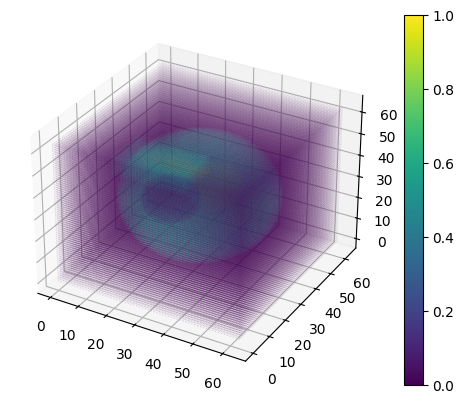

In [14]:
plot_voxel_grid(voxel_grid)

In [15]:
vol_geom = astra.create_vol_geom(
    int(volume_size[0]), 
    int(volume_size[1]), 
    int(volume_size[2]),
)
angles = np.linspace(-np.pi, np.pi, 180)

# For now we let the detector resolution be same as the volume size
detector_resolution = np.array([volume_size[0], volume_size[1]])
proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, detector_resolution[0], detector_resolution[1], angles)

In [16]:
proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, detector_resolution[0], detector_resolution[1], angles)

volume_id = astra.data3d.create('-vol', vol_geom, voxel_grid)
proj_id = astra.create_projector('cuda3d', proj_geom, vol_geom)
sinogram_id, sinogram = astra.create_sino3d_gpu(volume_id, proj_geom, vol_geom, returnData=True)
sinogram = np.moveaxis(sinogram, 0, 1)

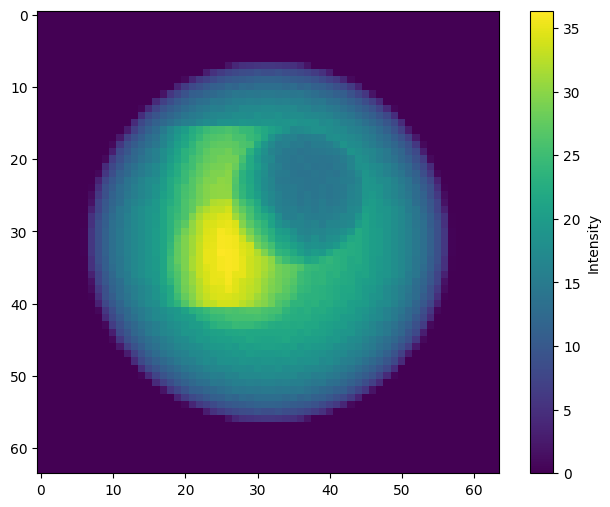

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(sinogram[20], cmap='viridis')
plt.colorbar(img, label='Intensity')

## Inject our variables

We need to inject the following 
```python
images = torch.from_numpy(sinogram).to(device)
tform_cam2world = # From the previous transformation code
height, width = 64, 64
focal_length = <your_focal_length_value>
near_thresh = <near_bound_value>
far_thresh = <far_bound_value>
testpose = tform_cam2world[<some_index>]  # or generate a novel view matrix
```


In [18]:
focal_length = focal_length
images = torch.from_numpy(sinogram).to(device)

angles = torch.tensor(np.linspace(-np.pi, np.pi, 180), device=device)
tform_cam2world = []
for angle in angles:
    # Rotation matrix around z-axis
    R = torch.tensor([
        [torch.cos(angle), -torch.sin(angle), 0, 0],
        [torch.sin(angle), torch.cos(angle),  0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ], dtype=torch.float32, device=device)

    # Append to list
    tform_cam2world.append(R)

# Stack into a single tensor
tform_cam2world = torch.stack(tform_cam2world)
height, width = images.shape[1:3]
testimg, testpose = images[101], tform_cam2world[101]

focal_length.dtype, images.dtype, tform_cam2world.dtype, testpose.dtype, height, width, near_thresh, far_thresh, 

(torch.float64, torch.float32, torch.float32, torch.float32, 64, 64, 2.0, 6.0)

#### Display the image used for testing

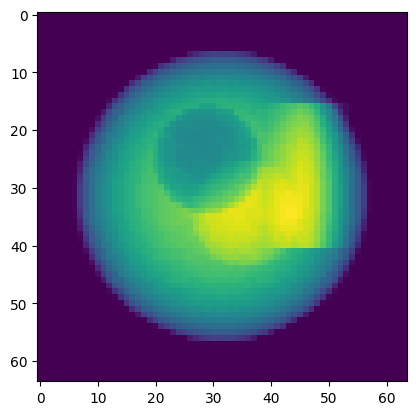

In [19]:
plt.imshow(testimg.detach().cpu().numpy())
plt.show()

## Train TinyNeRF!

(The cool part!)

In [20]:
# One iteration of TinyNeRF (forward pass).
def run_one_iter_of_tinynerf(model, height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):

  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)

  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # "Flatten" the query points.
  flattened_query_points = query_points.reshape((-1, 3))

  # Encode the query points (default: positional encoding).
  encoded_points = encoding_function(flattened_query_points)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  batches = get_minibatches_function(encoded_points, chunk_size=chunk_size)
  predictions = []
  for batch in batches:
    predictions.append(model(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted

In [21]:
from dataclasses import dataclass
from typing import Callable

@dataclass
class TinyNeRFConfig:
    height: int
    width: int

    input_images : torch.Tensor
    input_tform_cam2world : torch.Tensor
    input_focal_length : float

    test_idx : int

    near_thresh: float
    far_thresh: float

    depth_samples_per_ray: int
    encoding_fn: Callable
    chunk_size: int


def display_checkpoint(checkpoint_idx: int, rgb_predicted: torch.Tensor, iter_nums: list, psnrs: list):
    """Display the checkpoint images and PSNR values during training."""
    plt.figure(figsize=(4, 4))
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Iteration: {iter_nums[checkpoint_idx]} | PSNR: {psnrs[checkpoint_idx]:.2f}")
    plt.axis('off')
    plt.show()

In [22]:
def query_nerf(model, config, tform):
    return run_one_iter_of_tinynerf(
        model,
        config.height,
        config.width,
        config.input_focal_length,
        tform,
        config.near_thresh,
        config.far_thresh,
        config.depth_samples_per_ray,
        config.encoding_fn,
        get_minibatches
    )

In [23]:
def monochrome_to_rgb(image : torch.Tensor) -> torch.Tensor:
    image = torch.stack([image, image, image], dim=-1)
    return image / image.max()

In [24]:
def train(
        model_type: VeryTinyNerfModel,
        config: TinyNeRFConfig,
        num_iterations: int,    
        learning_rate=1e-4,
    ) -> tuple[torch.nn.Module, list[float]]:
    # Initialize model with encoding functions
    model = model_type(num_encoding_functions=6).to(device)  # Add parameter
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    num_checkpoints = 10
    psnrs = []
    iter_nums = []
    losses = []
    
    plt.imshow(config.input_images[config.test_idx].detach().cpu().numpy())
    plt.show()

    ref_tform = config.input_tform_cam2world[config.test_idx]
    
    for i in range(int(num_iterations)):
        j = np.random.randint(config.input_images.shape[0])
        target_img = monochrome_to_rgb(config.input_images[j].to(device))  # Fixed variable name
        target_tform = config.input_tform_cam2world[j].to(device)
        
        predicted_rgb = query_nerf(model, config, target_tform)
        loss = torch.nn.functional.mse_loss(predicted_rgb, target_img)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        
        # Record progress statistics using the already computed loss
        psnr = -10 * torch.log10(loss) 
        psnrs.append(psnr.item())
        iter_nums.append(i)
        losses.append(loss.item())
        
        if i % (num_iterations // num_checkpoints) == 0:
            ref_img = query_nerf(model,config,  ref_tform)
            # Fix display_checkpoint to use the current checkpoint index
            checkpoint_idx = len(psnrs) - 1
            display_checkpoint(checkpoint_idx, ref_img, iter_nums, psnrs)
    
    print(f"Done!\n\tFinal PSNR: {psnrs[-1]}")
    return model, psnrs

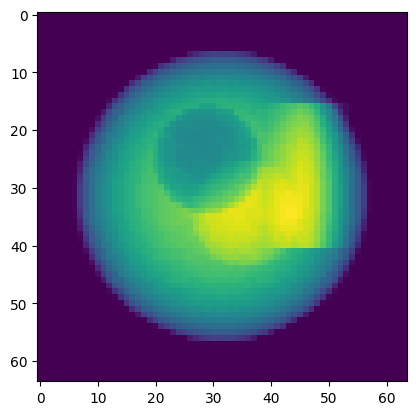

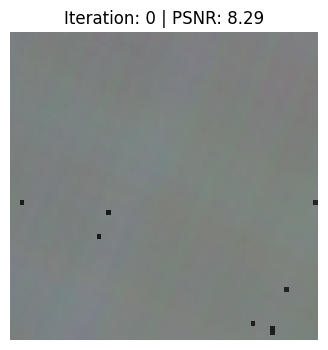

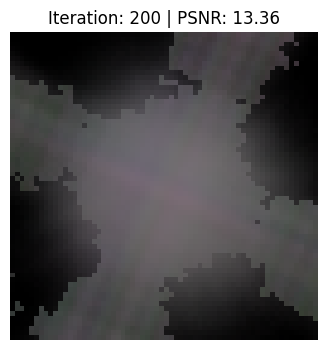

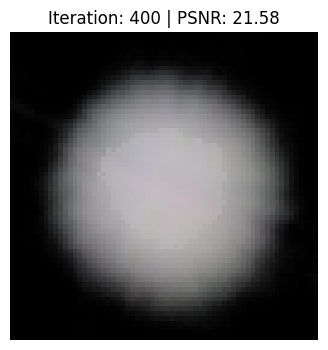

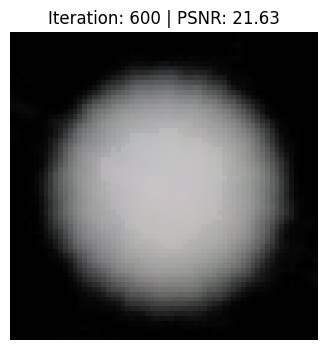

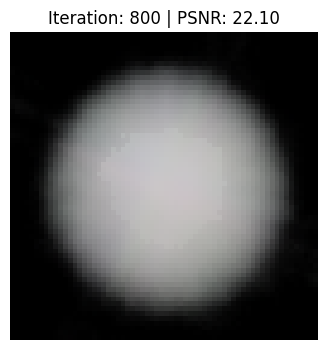

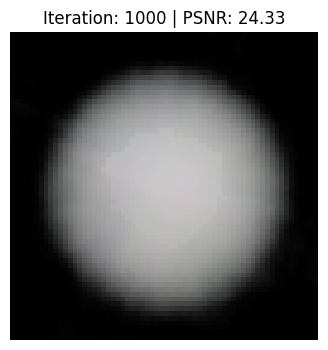

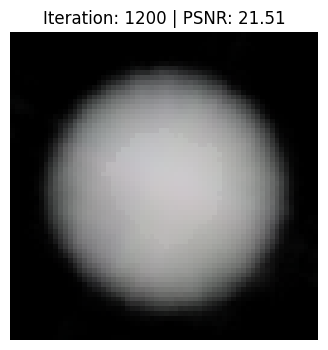

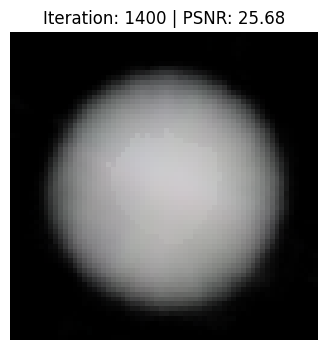

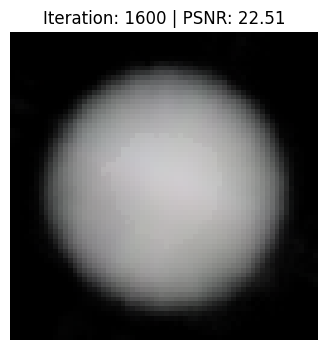

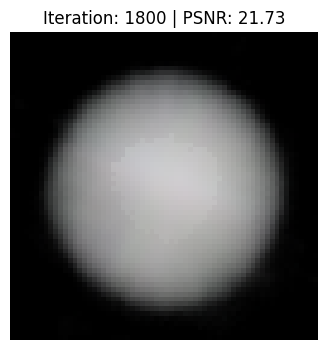

Done!
	Final PSNR: 22.6064510345459


In [25]:
chunk_size = 2**14

config = TinyNeRFConfig(
    height                      =height,
    width                       =width,
    input_images                =images,
    input_tform_cam2world       =tform_cam2world,
    input_focal_length          =focal_length,
    test_idx                    =101,
    near_thresh                 =near_thresh,
    far_thresh                  =far_thresh,
    depth_samples_per_ray       =64,
    encoding_fn                 =lambda x: positional_encoding(x, num_encoding_functions=6),
    chunk_size                  =chunk_size
)

seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

model, psnrs = train(
    model_type          =VeryTinyNerfModel,
    config              =config,
    num_iterations      =2e3,
    learning_rate       =1e-4
)

Loss: 0.0984107106924057


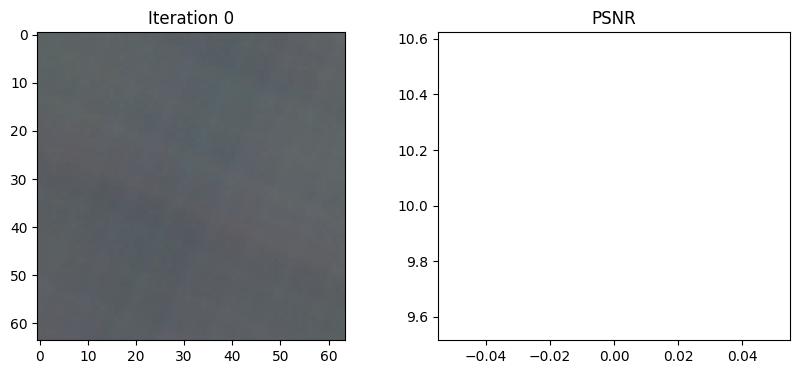

Loss: 0.007523267529904842


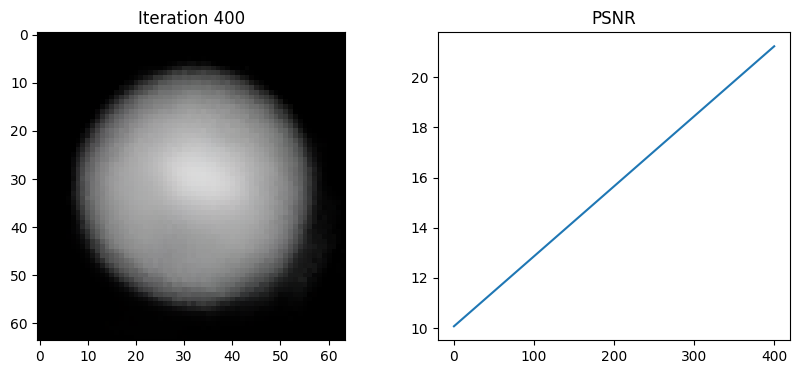

Loss: 0.006805642507970333


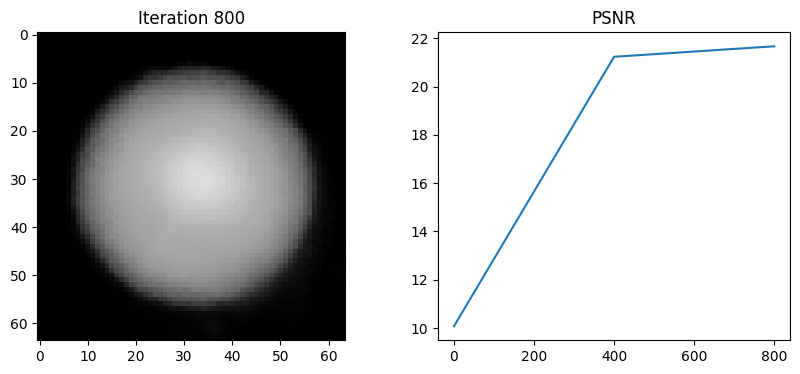

Loss: 0.01165490411221981


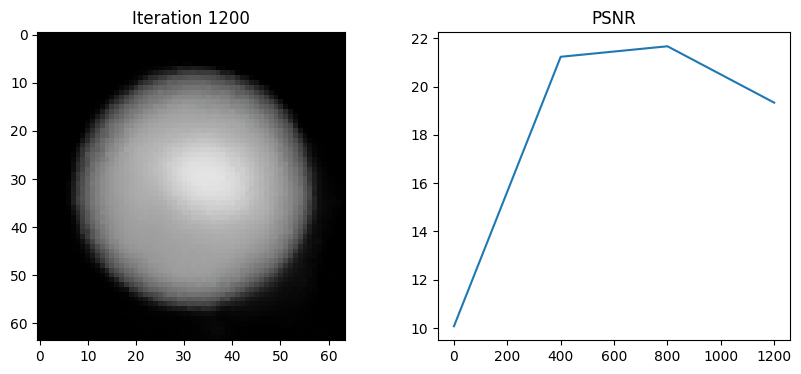

Loss: 0.008352383971214294


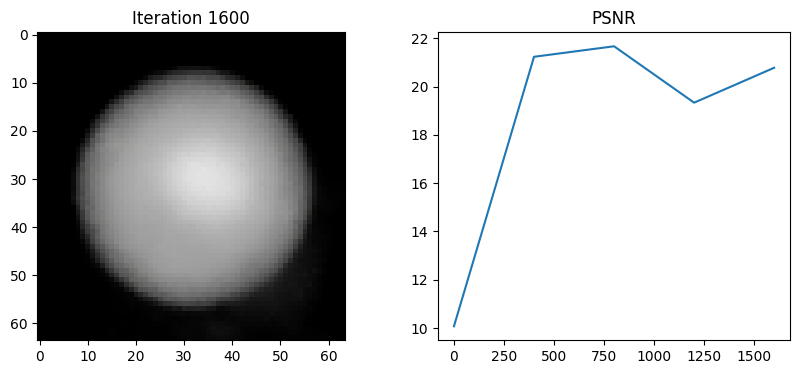

Done!


In [26]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunk_size = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 2e3

# Misc parameters
num_displays = 5  # Number of images to display

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

for i in range(int(num_iters)):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(images.shape[0])
  target_img = images[target_img_idx].to(device)
  # because its monochromatic for now we just take the first channel (64,64) -> (64,64,3)
  target_img = torch.stack([target_img, target_img, target_img], dim=-1)
  target_img = target_img / target_img.max()
  target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  predicted_rgb = run_one_iter_of_tinynerf(model, height, width, focal_length,
                                           target_tform_cam2world, near_thresh,
                                           far_thresh, depth_samples_per_ray,
                                           encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(predicted_rgb, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if i % (num_iters // num_displays) == 0:
    # Render the held-out view
    predicted_rgb = run_one_iter_of_tinynerf(model, height, width, focal_length,
                                             testpose, near_thresh,
                                             far_thresh, depth_samples_per_ray,
                                             encode, get_minibatches)
    loss = torch.nn.functional.mse_loss(predicted_rgb, target_img)
    print("Loss:", loss.item())
    psnr = -10. * torch.log10(loss)

    psnrs.append(psnr.item())
    iternums.append(i)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(predicted_rgb.detach().cpu().numpy())
    plt.title(f"Iteration {i}")
    plt.subplot(122)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.show()

print('Done!')

In [27]:
focal_length.dtype, images.dtype, tform_cam2world.dtype, testpose.dtype, height, width, near_thresh, far_thresh, 

(torch.float64, torch.float32, torch.float32, torch.float32, 64, 64, 2.0, 6.0)

In [28]:
def rgb_to_mono(rgb):
    # Assumes rgb is normalized to [0, 1]
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

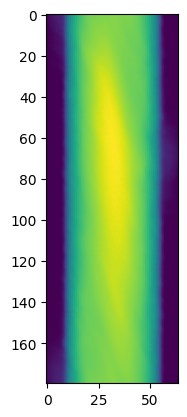

In [29]:
rgb_reconstruction = np.zeros((180, 64, 64))
for i,tform in enumerate(tform_cam2world):
    predicted_rgb = query_nerf(model, config, tform)
    y_hat = predicted_rgb.detach().cpu().numpy()
    rgb_reconstruction[i] = rgb_to_mono(y_hat)

sinogram = np.moveaxis(rgb_reconstruction, 0, 1)
plt.imshow(sinogram[23], cmap='viridis')

In [30]:
def create_gif(images, labels = None, template_str = None, output_filename = None, fps=10):
    if labels is None:
        labels = np.arange(len(images)) + 1
    if template_str is None:
        template_str = 'Image {}'
    if output_filename is None:
        output_filename = f"Animation {np.random.randint(0, 1000)}.gif" 
    
    fig, ax = plt.subplots(figsize=(8, 6))
    img = ax.imshow(images[0], cmap='viridis')
    plt.colorbar(img, label='Intensity')
    
    def update(frame):
        """Update function for animation"""
        # Clear the current plot
        ax.clear()
        
        # Create new image
        img = ax.imshow(images[frame], cmap='viridis')
        ax.set_title(template_str.format(labels[frame]))
        
        return [img]
    anim = FuncAnimation(
        fig, 
        update,
        frames=len(images),
        interval=1000/fps,  # interval in milliseconds
        blit=True
    )
    anim.save(
        output_filename,
        writer='pillow',
        fps=fps
    )
    plt.close()

In [31]:
def reconstruct_3d_volume_alg(sinogram, proj_geom, vol_geom, num_iterations=4):
    sinogram_id = astra.data3d.create('-proj3d', proj_geom, sinogram)
    reconstruction_id = astra.data3d.create('-vol', vol_geom)
    
    # Initialize algorithm parameters
    alg_cfg = astra.astra_dict('SIRT3D_CUDA')
    alg_cfg['ProjectionDataId'] = sinogram_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)

    astra.algorithm.run(algorithm_id, num_iterations)
    reconstruction = astra.data3d.get(reconstruction_id)
    
    astra.algorithm.delete(algorithm_id)
    astra.data3d.delete(sinogram_id)
    astra.data3d.delete(reconstruction_id)
    
    return reconstruction

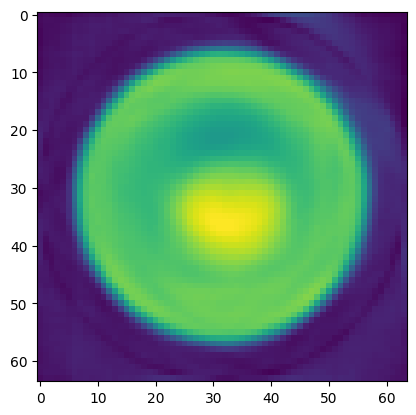

In [32]:
recon_alg = reconstruct_3d_volume_alg(sinogram, proj_geom, vol_geom, 55)
recon_alg = (recon_alg - recon_alg.min()) / (recon_alg.max() - recon_alg.min())
plt.imshow(recon_alg[32], cmap='viridis')

In [33]:
create_gif(
    rgb_reconstruction,
    np.linspace(-180, 180, len(rgb_reconstruction)),
    'Sinogram Slice (Angle: {:.2f}°)',
    'scanner_images_nerf-ref.gif'
)

In [34]:
create_gif(
    recon_alg,
    np.linspace(-1, 1, len(recon_alg)),
    'Reconstruction Slice (Z: {:.2f})',
    'ct_scan_nerf_alg-ref.gif'
)